HHU Deep Learning, WS2022/23, 09.12.2022

Lecture: Prof. Dr. Markus Kollmann

Exercises: Tim Kaiser, Nikolas Adaloglou

# Assignment 9 - Transfer Learning in Image Classification

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 16.12.2022 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/q1gV33QDw7C5RC8](https://uni-duesseldorf.sciebo.de/s/q1gV33QDw7C5RC8)

---

We will use `medmnist`, a python library that contains multiple medical imaging datasets for experimentation. You can install it locally via `pip install medmnist` or in google colab with `!pip install medmnist`

### The story

We found some pretrained resnet models on large-scale natural image data and we want to see if the learned weights are usefull for our medical image classification. 

- Task 1 and 2: To this end, we will first evaluate the [K-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (KNN) accuracy, using features from a pretrained resnet. We will compare the representations of resnet18 and resnet50
- Task 3: Next, we will use the features as training data, instead of the images, and train an MLP on top.
- Task 4: We will try to avoid overfitting by applying regularization techniques.
- Task 5: We will train the whole network (resnet50), starting from pretrained imagenet weights.
- Task 6: Finally, we compute the nearest neighbors and visualize them from the pretrained model.

Our new goal is to reach a 95% val. accuracy on pathmnist.

In [1]:
!git clone https://github.com/daleonpz/DL_09_Transfer_learning.git
%cd DL_09_Transfer_learning

fatal: destination path 'DL_09_Transfer_learning' already exists and is not an empty directory.
/content/DL_09_Transfer_learning


In [2]:
!pip install medmnist; 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# General imports and constants
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch


import data.dataset as ds
import mymodels.knnconnect 

from utils import *

BATCH_SIZE = 256
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


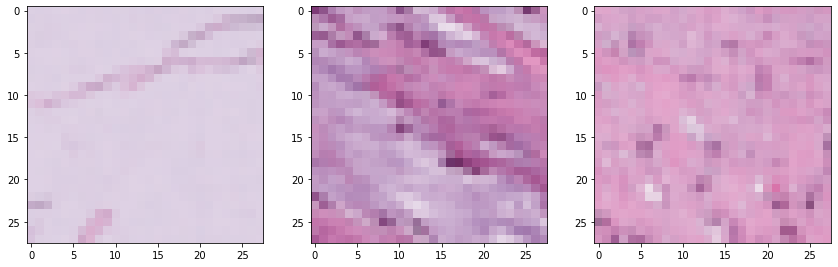

In [4]:
# Load dataset 
dataset_manager  = ds.DataSet()
train_ds_plain, val_ds, test_ds = dataset_manager.load_datasets()

# Load data 
train_loader_plain1 = data.DataLoader(dataset=train_ds_plain, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=True, drop_last=True)

img1, lab = next(iter(train_loader_plain1))

plt.figure(figsize = (50,20))
for i in range(3):
    imshow(train_ds_plain[i][0], i, dataset_manager.mean, dataset_manager.std)


# Task 1

Implement the logic of using a pretrained model to produce embeddings and apply KNN on top.
More precisly, given a pretrained model and a train and test loader, it computes the embeddings (on the gpu) and then uses the class `sklearn.neighbors.KNeighborsClassifier` to create a classifier. The classifier is created from the train embeddings and computes the train and test accuracy for both data splits.

### Optional - encapsulate the logic in a class
You can encapsulate the aforementioned logic by filling up the methods in the class below.
Minimal documentation is provided for each class method.
The method `execute` illustrates how the class methods should be used.

```python
class KnnConvnet():
    def __init__(self, model, device='cpu', distance='cosine'):
        super(KnnConvnet, self).__init__()
    def get_features(self, mode='train'):
    def set_features(self, embeds, labels, mode='train'):
    def extract_features(self, loader):
    def fit(self, features, labels, k):
    def predict(self, features, labels):
    
    @torch.no_grad()
    def execute(self, train_loader, test_loader=None, k=1):
        if self.embeds_train is None:
            embeds_train, lab_train = self.extract_features(train_loader)
            self.set_features(embeds_train, lab_train, mode='train')
        
        self.fit(self.embeds_train, self.lab_train, k)
        train_acc = self.predict(self.embeds_train, self.lab_train)

        if test_loader is not None:
            if self.embeds_test is None:
                embeds_test, lab_test = self.extract_features(test_loader)
                self.set_features(embeds_test, lab_test, mode='test')
            
            test_acc = self.predict(self.embeds_test, self.lab_test)
            return train_acc, test_acc
        
        return train_acc
```


#### Tips

- Feature extraction is much much faster on the GPU
- You can use `sklearn.model_selection.cross_val_score ` to calculate the accuracy.
- Use the cosine similarity as a distance metric 
 

In [ ]:
train_ds_plain.info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'task': 'multi-class',
 'label': {'0': 'adipose',
  '1': 'background',
  '2': 'debris',
  '3': 'lymphocytes',
  '4': 'mucus',
  '5': 'smooth muscle',
  '6': 'normal colon mucosa',
  '7': 'cancer-associated stroma',
  '8': '

In [ ]:
!git pull
import importlib
importlib.reload(ds)
importlib.reload(mymodels.knnconnect)

device = "cuda" if torch.cuda.is_available() else "cpu"

d1 = torch.utils.data.Subset(train_ds_plain, list(range(30000)))
d2 = torch.utils.data.Subset(val_ds, list(range(5000)))

train_loader = torch.utils.data.DataLoader(
        dataset=d1, batch_size=256, shuffle=False, drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
        dataset=d2, batch_size=256, shuffle=False, drop_last=False
    )

model   = torchvision.models.resnet18(pretrained=True)
model   = get_model("resnet18")
knn_cls = mymodels.knnconnect.KnnConvnet(model, device=device)
train_acc, test_acc = knn_cls.execute(train_loader, test_loader, k=10)
print(f"train acc: {train_acc:.2f}%, test acc: {test_acc:.2f}%")



Already up to date.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train acc: 79.69%, test acc: 75.30%


# Expected results

The training accuracy varies from 48% to 60%.
Test accuracy should be 54%
Examples:
```
train acc: 51.00%, test acc: 54.00%
train acc: 53.67%, test acc: 54.00%
train acc: 52.00%, test acc: 54.00%
train acc: 48.67%, test acc: 54.00%
train acc: 49.67%, test acc: 54.00%
train acc: 60.00%, test acc: 54.00%
```


# Task 2: Use the KNN classifier on pretrained features of resnet50

Now we will use the KNN class together with two models: resnet50 and resnet18. These are out-of-the-box models, available in the `torchvision` package.  

- Load the resnet18 and resnet50 models from `torchvision`, pretrained on the imagenet dataset.
- Remove the last layer (use print(model) to see what it's called).
- Compute the image embeddings for all training and test data, using the `extract_features` function. These now serve as our new, transformed data. We will use the validation dataloader as test data. 
- Find the best choice of K in KNN (hyperparameter search). Try at least 4 different values of K for both models.
- Plot the results in a scatter plot for both resnet18 and resnet50.
- **Important: save the image embeddings** from resnet50 for the next task (i.e. with `torch.save`).

PS: Use the non-augmented train and validation dataloaders.

You are expected to observe at least 72% val accuracy with resnet50. 

Hint: those working with google colab you can download files with:

```python
from google.colab import files
import pandas as pd
# saves file to local google colab enviroment
result.to_csv('example_file.csv')
# downloads it to your computer
files.download('example_file.csv')
```
It works with any type of file.

[Alternativly, you can mount you google drive storage into colab](https://stackoverflow.com/questions/50168315/mounting-google-drive-on-google-colab)

Make sure you save the embeddings in any case.

In [5]:
def get_model(modelname, pretrained=True):
    ### START CODE HERE ### (approx. 2 lines)
    if modelname == 'resnet18':
      model = torchvision.models.resnet18(pretrained=pretrained)
    else:
      model = torchvision.models.resnet50(pretrained=pretrained)
    model.fc = nn.Flatten() # the layer before is [m,n,1,1] but we only need [m,n]
     # nn.Identity() also works

    ### END CODE HERE ###
    return model

def run_knn_hp_tuning(model, train_loader, test_loader,
                        range_k = [5, 10, 15, 20], device='cpu', modelname='resnet18'):
    train_acc_all = []
    val_acc_all = []
    
    knn_cls = mymodels.knnconnect.KnnConvnet(model, device)

    ### START CODE HERE ### (> 10 lines)
    for k in range_k:
  
      train_acc, test_acc = knn_cls.execute(train_loader, test_loader, k=k)
      train_acc_all.append(train_acc)
      val_acc_all.append(test_acc)
  
    ### END CODE HERE ###

    return train_acc_all, val_acc_all

In [ ]:
train_loader_plain2 = data.DataLoader(dataset=train_ds_plain, batch_size=256, 
                                      shuffle=True, drop_last=False)
val_loader = data.DataLoader(dataset=val_ds, batch_size=256, 
                             shuffle=False, drop_last=False)

backbone_r18 = get_model("resnet18")
backbone_r50 = get_model("resnet50")

range_k = [5,10,15,20]
train_acc_r18, val_acc_r18 = run_knn_hp_tuning(backbone_r18, train_loader_plain2,
    val_loader, range_k, DEVICE, modelname="resnet18")

train_acc_r50, val_acc_r50 = run_knn_hp_tuning(backbone_r50, train_loader_plain2,
    val_loader, range_k, DEVICE, modelname="resnet50")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
def plot_knn_accs(range_k, train_acc_all, val_acc_all,  modelname='resnet18'):
    plt.plot(range_k, train_acc_all, marker='o', label=f'{modelname} train acc %')
    plt.plot(range_k , val_acc_all, marker='x', label=f"{modelname} val. acc %")

plt.figure(figsize=(12, 6))
plot_knn_accs(range_k, train_acc_r18, val_acc_r18,  modelname='resnet18')
plot_knn_accs(range_k, train_acc_r50, val_acc_r50,  modelname='resnet50')
plt.legend( bbox_to_anchor=(1,1), loc="upper left")
plt.grid()
plt.xticks([]) # hides x axis
plt.xlabel("k")
plt.ylabel(f"Accuracy %")
plt.title("Benhmarking resnet18 and resnet50 embeddings with KNN")
plt.savefig("./figs/knn_accs_res_.png", dpi=400, bbox_inches='tight')
plt.show()

# Task 3: Train an MLP on the extracted image features from resnet50

- Create new datasets and dataloaders that return a pair of (features, labels) from resnet50 instead of the image. 

Since we have precomputed the features, you can use `torch.load` here to load the features and labels and `torch.utils.data.TensorDataset` to make a dataset.

- Train a 2-layer MLP with a ReLU activation on the extracted features from the pretrained resnet50 as input data. 
- Train for at least 100 epochs with Adam.
- Expected val accuracy is 84%

Hint: For small models, just nn.Sequential produces a fully functioning model. You don't need to define an extra class here.

In [6]:
# load embeds from hard disk
!git pull
import importlib
importlib.reload(ds)
importlib.reload(mymodels.knnconnect)



train_loader = torch.utils.data.DataLoader(
        dataset=train_ds_plain, batch_size=1024, shuffle=True, drop_last=False
    )
val_loader = torch.utils.data.DataLoader(
        dataset=val_ds, batch_size=1024, shuffle=False, drop_last=False
    )


model   = get_model("resnet50")
knn_50 = mymodels.knnconnect.KnnConvnet(model, device=DEVICE)

x_train, y_train = knn_50.extract_features(train_loader) # One forward pass and get the output
x_val, y_val = knn_50.extract_features(val_loader)

Already up to date.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import data.customdataset as custom_ds
train_ds      = custom_ds.CustomDataset(x_train, y_train)
train_loader  = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds        = custom_ds.CustomDataset(x_val, y_val)
val_loader    = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
train_ds.__len__()

89996

In [11]:
len(train_ds_plain.info['label'])

9

In [12]:
x_train.shape

torch.Size([89996, 2048])

Init Accuracy of the model: Train:4.404 	 Val:4.278289


Ep 99/100: Accuracy : Train:86.18 	 Val:82.90 || Loss: Train 0.375 	 Val 0.486: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


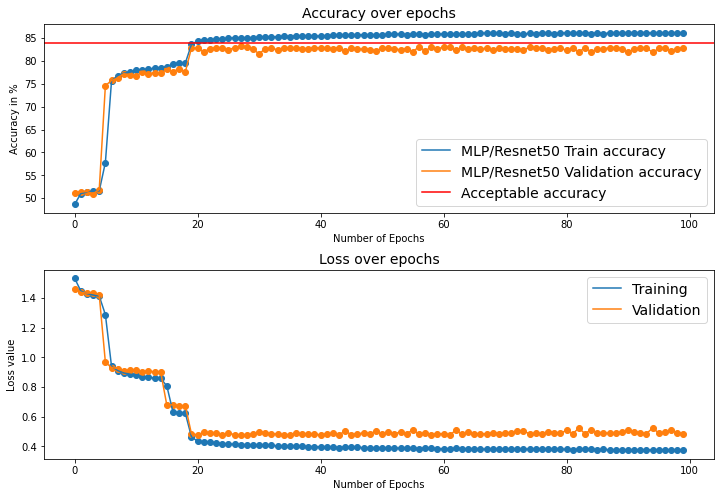

Best val. acc 83.20672


In [10]:

import mymodels.minimodelMLP as mlp
num_epochs = 100

model = mlp.MiniModel(x_train.shape[1]).to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=0.0001)
dict_log = train(model, optimizer, num_epochs, train_loader, val_loader, DEVICE)
# dict_log = train(model, optimizer, num_epochs, train_loader_features, val_loader_features, device)

figsize = (12,8)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=84, modelname="MLP/Resnet50")
#plt.savefig(fname="./figs/mlp_res50_students_out.png", dpi=400, bbox_inches='tight')
plt.show()
print("Best val. acc", np.max(dict_log["val_acc_epoch"]))

# Task 4: Regularization strategies
If you trained the model, you should be able to see the overfitting behaviour with a degradation in loss/accuracy towards the end of training.

What regularization strategies could you use to prevent the model from overfitting? 

Experiment with at least 1 regularization strategy (apart from tuning the weight decay) and see if you can further increase the performance.

- Does regularization lead to performance improvement?
- How do the training dynamics change when training with stronger regularization strategies?

Init Accuracy of the model: Train:13.003 	 Val:12.994802


Ep 99/100: Accuracy : Train:84.52 	 Val:83.19 || Loss: Train 0.431 	 Val 0.464: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


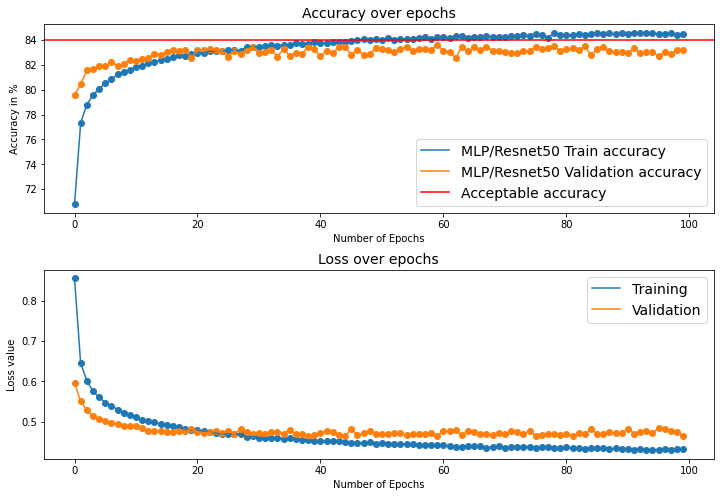

Best val. acc 83.60656


In [13]:
model = nn.Sequential(nn.Linear(2048, 128), nn.Dropout(0.6), nn.Linear(128, 9),nn.ReLU(inplace=True) )

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4, weight_decay=0.0001)

num_epochs = 100
dict_log = train(model, optimizer, num_epochs, train_loader, val_loader, DEVICE)

figsize = (12,8)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=84, modelname="MLP/Resnet50")
plt.show()
print("Best val. acc", np.max(dict_log["val_acc_epoch"]))

# Task 5: Train the whole model (resnet50) on pathmnist starting from imagenet initialization.

Now we will re-train the whole model, using the pretrained weights as a starting point. Also, we add data-augmentation, see below for details.

Training data augmentations:
- Horizontal flip with 50% probability
- Random crop images to 50-100 % of the initial size
- Resize images to 28x28
- intensity jitter: 20% brightness and 20% contrast with 80% probability
- Mean/std norm with mean=0.5 and std=0.5 for all channels

At val/test time, only mean/std normalization will be applied.


Do the following:
- Load a pretrained resnet50. Remove the pretrained head (last layer). Add a two-layer MLP as the new last layer.
- Compute the number of trainable and non-trainable parameters.
- Train for 20 epochs.
- Plot training statistics
- Calculate test accuracy!


Compare the fine-tuned resnet50 on the pathmnist dataset with the previously trained MLP on the extracted features.

Expected val. acc is 95%

In [ ]:
# aoueaueaouueaou eaouteuhseanohu  

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Total params: 23.8 M , trainble params 23.8
Init Accuracy of the model: Train:8.952 	 Val:9.174680


Ep 19/20: Accuracy : Train:94.31 	 Val:94.45 || Loss: Train 0.165 	 Val 0.159: 100%|██████████| 20/20 [32:04<00:00, 96.24s/it]


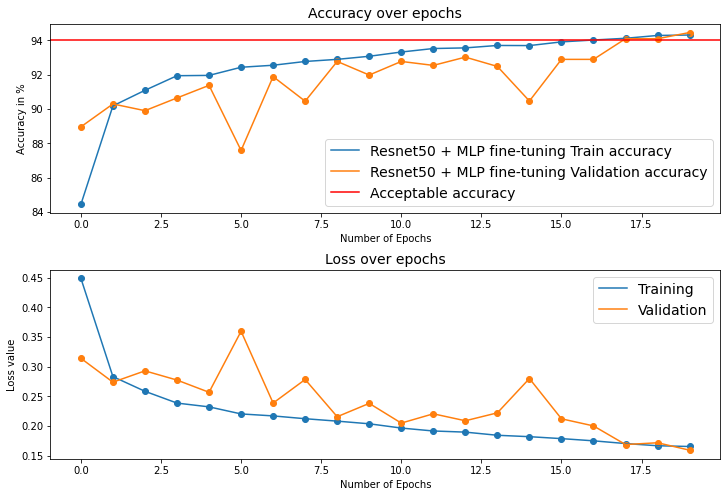

In [30]:
from torchvision import transforms as T
import medmnist
from medmnist import INFO
import torchvision
import torch.nn as nn

# Specify transforms, maps from [0,1] to [-1,1]
mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

### START CODE HERE ### (approx. 7 lines)
train_transform= T.Compose(
    [T.ToTensor(), 
     T.RandomHorizontalFlip(0.5),
     T.RandomResizedCrop(size=(28,28), scale=(0.5,1)),
     T.RandomApply( [T.ColorJitter(brightness=0.2, contrast=0.2)] , p=0.8), 
     T.Normalize(list(mean), list(std))
     ]
)
### END CODE HERE ###

# For val/time define a plain transform
plain_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(list(mean), list(std))])

info = INFO['pathmnist']
DataClass = getattr(medmnist, info["python_class"])
# load the data
train_ds  = DataClass(split='train',  transform=train_transform, download=True)
val_ds    = DataClass(split='val',    transform=plain_transform, download=True)
test_ds   = DataClass(split='test',   transform=plain_transform, download=True)

train_loader  = data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader    = data.DataLoader(dataset=val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader   = data.DataLoader(dataset=test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# create model
class ResnetMedNist(nn.Module):
    def __init__(self, hidden_mlp, n_classes):
        super(ResnetMedNist, self).__init__()
        ### START CODE HERE ### (approx. 3 lines)
        self.backbone = torchvision.models.resnet50(True)
        self.backbone.fc = nn.Identity()
        self.mlp = nn.Sequential(nn.Linear(2048, hidden_mlp),
                                 nn.Linear(hidden_mlp, n_classes),
                                 nn.ReLU(inplace=True)
                                 )
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (approx. 1 lines)
        return self.mlp(self.backbone(x))
        ### END CODE HERE ###


# Initialize model and optimizer
num_epochs = 20
### START CODE HERE ### (approx. 2 lines)
model = ResnetMedNist(128, 9)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.001)
### END CODE HERE ###


# Number of parameters
### START CODE HERE ### (approx. 2 lines)
pytorch_total_params = sum(p.numel() for p in model.parameters()) / 1000000
pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000
### END CODE HERE ###
print(f" Total params: {pytorch_total_params:.1f} M , trainble params {pytorch_total_params_trainable:.1f}")

dict_log = train(model, optimizer, num_epochs, train_loader, val_loader, DEVICE)

figsize = (12,8)
plt.figure(figsize=figsize)
plot_stats(dict_log, baseline=94, modelname="Resnet50 + MLP fine-tuning")
plt.show()